# ネットワーク指標の統計解析
ランダム化ネットワークを使って，大腸菌のタンパク質相互作用ネットワークを例にして次のネットワーク指標の統計的有意性の評価を行います。
* 平均クラスタ係数
* 平均最短経路長

networkxの読み込み

In [1]:
import networkx as nx

その他ライブラリ

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.csgraph as csgraph
from scipy import stats

igraphも使う（networkxのコンフィギュレーションモデルは自己ループや多重エッジの生成を許し、サンプリングに偏りがあるという問題があるので、igraphのものを使用）

In [3]:
!pip install igraph

In [4]:
import igraph as ig

平均最短経路長を計算する関数（networkxのは遅いので）

In [5]:
def compute_distances(g, unweighted=False):
  adj_matrix = nx.adjacency_matrix(g).toarray()
  distances = csgraph.shortest_path(adj_matrix, directed=g.is_directed(), unweighted=unweighted)
  d_ave = np.mean(distances[np.isfinite(distances) & (distances > 0)])
  return d_ave, distances

## 大腸菌のタンパク質相互作用ネットワークの読み込み
* `../data/ecoli_ppi_Hu_etal_2009.txt`
* エッジリスト形式
* Hu P, Janga SC, Babu M, Díaz-Mejía JJ, Butland G, et al. Global functional atlas of Escherichia coli encompassing previously uncharacterized proteins. PLoS Biol. 2009 Apr 28;7(4):e96. doi: [10.1371/journal.pbio.1000096](https://doi.org/10.1371/journal.pbio.100009).

In [6]:
# エッジリストの読み込み
df = pd.read_csv("https://raw.githubusercontent.com/kztakemoto/network-analysis-in-biology/refs/heads/main/data/ecoli_ppi_Hu_etal_2009.txt", sep='\s+', header=None)

# グラフオブジェクトの作成
g = nx.from_pandas_edgelist(df, source=0, target=1)
g = nx.Graph(g)  # 多重エッジを削除
g.remove_edges_from(nx.selfloop_edges(g))  # 自己ループを削除

# 最大連結成分の取得
lcc = max(nx.connected_components(g), key=len)
g = g.subgraph(lcc)

## 現実のネットワークの平均クラスタ係数を計算

In [7]:
cc_real = nx.average_clustering(g)

## 現実のネットワークの平均最短経路長を計算

In [8]:
apl_real, _ = compute_distances(g)

## 100個のランダムネットワークを作成して，ネットワーク指標を計算する。
平均クラスタ係数と平均最短経路長

時間がかかります。

コンフィギュレーションモデルによるネットワークランダム化のための関数

In [9]:
def randomization(g_ori):
  # network to igraph
  g_ori = ig.Graph.from_networkx(g_ori)
  # 次数のベクトルを取得
  deg = g_ori.degree()
  # コンフィギュレーションモデルの作成
  g_rand = ig.Graph.Degree_Sequence(deg, method="vl")
  # igraph to networkx
  edgelist = g_rand.get_edgelist()
  g_rand = nx.Graph(edgelist)
  return g_rand

In [10]:
cc_null = []
apl_null = []

for i in range(100):
  g_null = randomization(g)

  # 平均クラスタ係数
  cc_null.append(nx.average_clustering(g_null))

  # 平均最短経路長
  apl_null_ind, _ = compute_distances(g_null)
  apl_null.append(apl_null_ind)


In [11]:
cc_null = np.array(cc_null)
apl_null = np.array(apl_null)

## Zスコアの計算

In [12]:
# 平均クラスタ係数
z_cc = (cc_real - np.mean(cc_null)) / np.std(cc_null)
# 平均最短経路長
z_apl = (apl_real - np.mean(apl_null)) / np.std(apl_null)

## 帰無分布と観測値（平均クラスタ係数）

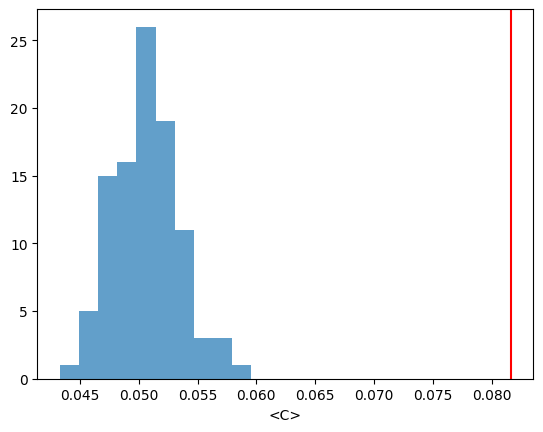

In [13]:
# ヒストグラムを描画
plt.hist(cc_null, bins='auto', alpha=0.7)
# x軸のラベルを設定
plt.xlabel("<C>")
# 観測値を赤線で表示
plt.axvline(x=cc_real, color='red')

## 帰無分布と観測値（平均最短経路長）

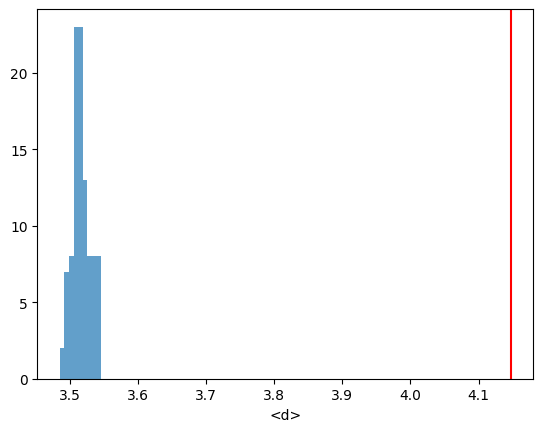

In [14]:
# ヒストグラムを描画
plt.hist(apl_null, bins='auto', alpha=0.7)
# x軸のラベルを設定
plt.xlabel("<d>")
# 観測値を赤線で表示
plt.axvline(x=apl_real, color='red')

## P値の計算

In [15]:
# 平均クラスタ係数に対するP値（両側）
2 * stats.norm.cdf(-abs(z_cc))

8.146306909685583e-28

In [16]:
# 平均最短経路に対するP値（両側）
2 * stats.norm.cdf(-abs(z_apl))

0.0

## 経験的P値の計算

In [17]:
# 平均クラスタ係数に対するP値（上側）
np.sum(cc_null > cc_real) / len(cc_null)

0.0

In [18]:
# 平均最短経路に対するP値（上側）
np.sum(apl_null > apl_real) / len(apl_null)

0.0

## スモールワールド性指標
Humphries MD, Gurney K (2008) Network ‘Small-World-Ness’: A Quantitative Method for Determining Canonical Network Equivalence. PLoS ONE 3(4): e0002051. [https://doi.org/10.1371/journal.pone.0002051](https://doi.org/10.1371/journal.pone.0002051)

In [19]:
cc_real * np.mean(apl_null) / apl_real / np.mean(cc_null)

1.3644288728330065